## Obteniendo todos los tweets de un usuario

In [1]:
import requests
import json
import pandas as pd
import tweepy

In [2]:
#pip install --upgrade tweepy  # needed v.4

In [7]:
# LA LLAVE
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAF02cQEAAAAAAw4Ko%2BlvaP%2FEKo4jetBjHN%2BGEpY%3D8ot7Zeg7DytI7xLRXuZO23cSWSLBIAHPMKrw9b8jebi9j7nWsI"

#Extracción de data a partir del @username.
Basado en Tweepy v4.9.0

In [14]:
input_user = 'AgenteLibreCL' #Aquí se coloca el usuario al que se quiere revisar

In [9]:
def extract_tweet_data(input_user):
    """
    Extracts data from a Twitter account.

    Parameters:
    input_user: str
        Twitter account to be analysed (without the @).

    Returns:
    pd.DataFrame
        A dataframe of the user tweets containing, time of creation,
        text, tweet id, number of retweets and number of likes.
    """
    # Authorize access
    client = tweepy.Client(BEARER_TOKEN)

    # Get user ID from username
    user_id = client.get_user(username=input_user).data.id

    # Get Tweets timeline (check all pages, max 100 tweets per page, max 32 pages)
    df_list = []
    df_len0 = []
    df_len = []
    for response in tweepy.Paginator(client.get_users_tweets, user_id,
                                    tweet_fields='created_at,lang,public_metrics',
                                    max_results=100, limit=32):
        page_df = pd.DataFrame.from_dict(response.data)
        df_len0.append(len(page_df))
        # Delete non-spanish tweets
        page_df = page_df.drop(page_df[page_df.lang !='es'].index)
        page_df = page_df.drop(['lang'], axis=1)
        df_len.append(len(page_df))
        # Organize columns
        retweet_count = []
        like_count = []
        for item in page_df['public_metrics'].tolist():
          retweet_count.append(item['retweet_count'])
          like_count.append(item['like_count'])
        page_df = page_df.drop(['public_metrics'], axis=1)
        page_df['retweet_count'] = retweet_count
        page_df['like_count'] = like_count
        df_list.append(page_df)
    es_tweets = round(sum(df_len)*100/sum(df_len0),1)
    print(f'Obtained {es_tweets}% tweets in spanish from total of {sum(df_len0)} tweets from user @{input_user}.')
    tweets_df = pd.concat(df_list, ignore_index=True)
    return tweets_df

OLD EXTRACTION CODE (only works for obtaining user info, and only 100 tweets max)\
Es una modificación de los ejemplos para obtener [info del user](https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/User-Lookup/get_users_with_bearer_token.py) y [sus tweets](https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/User-Tweet-Timeline/user_tweets.py)


In [10]:
def create_url(username, twitter_object):
    if twitter_object == 'user':
      usernames = f'usernames={username}'
      user_fields = 'user.fields=description,created_at,protected,public_metrics,verified'
      url = f'https://api.twitter.com/2/users/by?{usernames}&{user_fields}'
    elif twitter_object == 'tweet':
      user_dict = get_json('user')
      user_id = user_dict['data'][0]['id']
      url = f'https://api.twitter.com/2/users/{user_id}/tweets?max_results=100'
    else:
      print('Error. Wrong Twitter Object.')
      return None
    return url


def get_params(twitter_object):
    if twitter_object == 'tweet':
      params = {"tweet.fields": "created_at,lang,public_metrics"}
    else:
      print('Error. Wrong Twitter Object.')
      return None
    return params


def bearer_oauth_user(r):
    r.headers["Authorization"] = f"Bearer {BEARER_TOKEN}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r


def bearer_oauth_tweet(r):
    r.headers["Authorization"] = f"Bearer {BEARER_TOKEN}"
    r.headers["User-Agent"] = "v2UserTweetsPython"
    return r


def connect_to_endpoint(url, twitter_object):
    if twitter_object == 'user':
      response = requests.request("GET", url, auth=bearer_oauth_user,)
    elif twitter_object == 'tweet':
      params = get_params('tweet')
      response = requests.request("GET", url, auth=bearer_oauth_tweet,params=params)
    else:
        print('Error. Wrong Twitter Object.')
        return None
    if response.status_code != 200:
        raise Exception(f'Request returned an error: {response.status_code} {response.text}')
    return response.json()


def get_json(username, twitter_object):
    if twitter_object == 'user':
      url = create_url(username, 'user')
      json_response = connect_to_endpoint(url, 'user')
    elif twitter_object == 'tweet':
      url = create_url(username, 'tweet')
      json_response = connect_to_endpoint(url, 'tweet')
    else:
        print('Error. Wrong Twitter Object.')
        return None
    return json_response


def extract_user_data(username):  # MAIN FILE
    """
    Extracts data from a Twitter account.

    Parameters:
    username: str
        Twitter account to be analysed (without the @).
    Returns:
    dict
        A dict containing the releveant variables about the user
    """
    # Get user ID from username
    user_dict = get_json(username, 'user')
    #user_id = user_dict['data'][0]['id']

    # Get Tweets timeline
    #tweet_dict = get_json('tweet')
    #tweet_pd = pd.DataFrame.from_dict(tweet_dict['data'])
    return user_dict

#Información del usuario extraida del API de twitter:

In [7]:
extract_user_data(input_user)  ## Información del usuario

{'data': [{'public_metrics': {'followers_count': 2452,
    'following_count': 2399,
    'tweet_count': 5505,
    'listed_count': 4},
   'protected': False,
   'verified': False,
   'name': 'Agente Libre',
   'id': '1258151518039085056',
   'username': 'AgenteLibreCL',
   'created_at': '2020-05-06T21:48:06.000Z',
   'description': 'Chileno. Vagabundo político. La exagerada respuesta al COVID-19 es un escándalo, y muchas autoridades deben rendir cuentas. A veces hago videos.'}]}

In [8]:
extract_tweet_data(input_user)  ## DataFrame con todos los tweets en español del usuario

Obtained 82.8% tweets in spanish from total of 3130 tweets from user @AgenteLibreCL.


,created_at,id,text,retweet_count,like_count
0,2022-05-09 21:04:58+00:00,1523771030581379072,"Fin de la semana 114 desde el primer ""caso"" de...",2,7
1,2022-05-08 23:44:03+00:00,1523448676214984704,@xBValentine3 Es impresionante lo mucho que el...,0,1
2,2022-05-08 23:43:36+00:00,1523448563803430912,@Moxi2e Y estamos recién empezando.,0,0
3,2022-05-08 23:33:54+00:00,1523446122705956864,Hay algo de tweet en tu chantaje. https://t.co...,7,23
4,2022-05-08 14:58:06+00:00,1523316317922545670,🤔\n\n[Y sigue sin mandar artículo alguno.] htt...,0,3
...,...,...,...,...,...
2588,2021-06-11 23:12:00+00:00,1403490229395365888,Si Jaime Mañalich tiene que salir a decir que ...,1,0
2589,2021-06-11 19:41:14+00:00,1403437185899155458,"Las mascarillas sirven tanto, que volvimos a l...",3,9
2590,2021-06-11 18:53:59+00:00,1403425295127007243,Imagina discriminar a otras personas para que ...,0,1
2591,2021-06-11 17:53:46+00:00,1403410142792753156,@GobiernodeChile Para estar bien informados an...,1,1


### Procesamiento de data

Limpieza y lematizacion de texto



In [9]:
def vars_word(word, input_df):
    """
    Compute the variables for a given word.

    Parameters:
    word: str
        Word to be analysed in the timeline tweets.
    input_df: pd.DataFrame
        A dataframe of the user tweets containing, time of creation,
        text, tweet id, number of retweets and number of likes.

    Returns:
    tuple(float, float, float, float, float):
        A tuple containing variables of the word: frequency, like rate, retweet
        rate, popularity, and polemicity
    tuple(float, float, float):
        A tuple containing counters of the word: number of times it appears
        on all the tweets, number of tweets it appears in, number of retweets it
        appears in.
    """

    df = input_df.copy()
    # Flatten text column
    splitted_tweets=df.clean_text.apply(lambda a: a.split()).tolist()#.count("datos")
    # Flatten text column
    total_word_list = [word_tweet for word_list in splitted_tweets for word_tweet in word_list]
    

    word_count = total_word_list.count(word)
    total_word_count = len(total_word_list)
    freq = word_count/total_word_count

    df['word_count'] = df.clean_text.map(lambda t: t.count(word))
    tweets_containing = df['word_count'].astype(bool).sum()
    #if tweets_containing == 0:
    #    return None
    df.drop(['word_count'], axis=1)
    # like_count_flag
    like_count = df[df['word_count'].astype(bool)]['like_count'].sum()
    retweet_count = df[df['word_count'].astype(bool)]['retweet_count'].sum()
    #if (like_count == 0) or (retweet_count == 0):
    #    return None
    like_rate = like_count/tweets_containing
    retweet_rate = retweet_count/tweets_containing

    popularity  = retweet_rate/freq
    polemicity  = retweet_rate/like_rate

    variables = (freq, like_rate, retweet_rate, popularity, polemicity)
    counters = (word_count, like_count, retweet_count)
    return variables, counters


def vars_cat(category, df):
    """
    Compute the variables for a given category.

    Parameters:
    category: list
        List of words to be analysed in group in the timeline tweets.
    df: pd.DataFrame
        A dataframe of the user tweets containing, time of creation,
        text, tweet id, number of retweets and number of likes.

    Returns:
    tuple(float, float, float):
        A tuple containing counters of the words in the category: number of
        times they appear on all the tweets, number of tweets they appears in,
        number of retweets they appear in.
    tuple(float, float, float):
        A tuple containing popularity and polemicity of the category.
    """

    category = [word for word in category if word]
    pop_cat = pol_cat = word_count_cat = like_count_cat = retweet_count_cat = 0
    for word in category:
        #if vars_word(word, df) is None:
        vars, counters = vars_word(word, df)
        pop_cat += counters[0] * vars[3]
        pol_cat += counters[0] * vars[4]
        word_count_cat += counters[0]
        like_count_cat += counters[1]
        retweet_count_cat += counters[2]

    pop_cat = pop_cat / word_count_cat
    pol_cat = pol_cat / word_count_cat

    cat_counters = (word_count_cat, like_count_cat, retweet_count_cat)
    pop_pol_cats = (pop_cat, pol_cat)
    return cat_counters, pop_pol_cats

## EDA

In [10]:
import itertools


import pandas as pd
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

In [11]:
# Load spacy
nlp = spacy.load('en_core_web_sm')

def clean_string(text, stem="None"):
    try:

        final_string = ""

        # minusculas
        text = text.lower()
        text = text.replace(" u "," ").replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u")

        # quitar salto de lineas
        emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
        text=emoji_pattern.sub(r'', text)
        # quitar signos gramaticales
        translator = str.maketrans('', '', string.punctuation)
        text = text.translate(translator)

        # stopwords
        text = text.split()
        useless_words = nltk.corpus.stopwords.words("spanish")
        useless_words = useless_words + ['...','considero','tal','vez','seria','debe','tener','siento', "dar", "hacer"
                            'estan','tan','parece','ademas','debido','cuenta','hace','cada','toda','si', "ser",
                                         "ma", "mas", "más","bien", "buena", "creo", "aun"]
        # 
        text_filtered = [word for word in text if not word in useless_words]

        # quitar numeros
        text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]
        

        # Lematizacion
        #if stem == 'Stem':
        #    stemmer = PorterStemmer() 
        #    text_stemmed = [stemmer.stem(y) for y in text_filtered]
        #elif stem == 'Lem':
        #    lem = WordNetLemmatizer()
        #    text_stemmed = [lem.lemmatize(y) for y in text_filtered]
        #elif stem == 'Spacy':
        #    text_filtered = nlp(' '.join(text_filtered))
        #    text_stemmed = [y.lemma_ for y in text_filtered]
        #else:
        #    text_stemmed = text_filtered

        #final_string = ' '.join(text_stemmed)
        final_string = ' '.join(text_filtered)

        # sinonimia
        #final_string = final_string.replace('docent','profesor')
    except AttributeError:
        final_string = ""

    return final_string

In [12]:
def ngrams_wrapper_1(sent):
    return list(nltk.ngrams(sent, 1))

def ngrams_wrapper_2(sent):
    return list(nltk.ngrams(sent, 2))

def ngrams_wrapper_3(sent):
    return list(nltk.ngrams(sent, 3))

In [13]:
def make_list_bigrams_1(text):
    sentences = nltk.sent_tokenize(text)
    tokenized = map(nltk.tokenize.word_tokenize, sentences)
    bigrams = map(ngrams_wrapper_1, tokenized)
    bigram = list(itertools.chain.from_iterable(bigrams))
    return bigram

def make_list_bigrams_2(text):
    sentences = nltk.sent_tokenize(text)
    tokenized = map(nltk.tokenize.word_tokenize, sentences)
    bigrams = map(ngrams_wrapper_2, tokenized)
    bigram = list(itertools.chain.from_iterable(bigrams))
    return bigram

def make_list_bigrams_3(text):
    sentences = nltk.sent_tokenize(text)
    tokenized = map(nltk.tokenize.word_tokenize, sentences)
    bigrams = map(ngrams_wrapper_3, tokenized)
    bigram = list(itertools.chain.from_iterable(bigrams))
    return bigram

In [14]:
def nlp_process_1(text):
    return '/'.join([str(i) for i in make_list_bigrams_1(clean_string(str(text), stem='Stem'))])

def nlp_process_2(text):
    return '/'.join([str(i) for i in make_list_bigrams_2(clean_string(str(text), stem='Stem'))])

def nlp_process_3(text):
    return '/'.join([str(i) for i in make_list_bigrams_3(clean_string(str(text), stem='Stem'))])
    

# Subida de los tweets del usuario

In [9]:
# dummy input (after cleaning)
o_df = extract_tweet_data(input_user)
#test_df = o_df.copy()
o_df

Obtained 82.8% tweets in spanish from total of 3130 tweets from user @AgenteLibreCL.


,created_at,id,text,retweet_count,like_count
0,2022-05-09 21:04:58+00:00,1523771030581379072,"Fin de la semana 114 desde el primer ""caso"" de...",2,7
1,2022-05-08 23:44:03+00:00,1523448676214984704,@xBValentine3 Es impresionante lo mucho que el...,0,1
2,2022-05-08 23:43:36+00:00,1523448563803430912,@Moxi2e Y estamos recién empezando.,0,0
3,2022-05-08 23:33:54+00:00,1523446122705956864,Hay algo de tweet en tu chantaje. https://t.co...,7,23
4,2022-05-08 14:58:06+00:00,1523316317922545670,🤔\n\n[Y sigue sin mandar artículo alguno.] htt...,0,3
...,...,...,...,...,...
2588,2021-06-11 23:12:00+00:00,1403490229395365888,Si Jaime Mañalich tiene que salir a decir que ...,1,0
2589,2021-06-11 19:41:14+00:00,1403437185899155458,"Las mascarillas sirven tanto, que volvimos a l...",3,9
2590,2021-06-11 18:53:59+00:00,1403425295127007243,Imagina discriminar a otras personas para que ...,0,1
2591,2021-06-11 17:53:46+00:00,1403410142792753156,@GobiernodeChile Para estar bien informados an...,1,1


Limpieza de los tweets

In [16]:
o_df["created_at"]=o_df["created_at"].apply(lambda a: pd.to_datetime(a).date())
o_df["clean_text"]=o_df["text"].apply(lambda x: clean_string(x))
o_df["bigram_key_words"]= o_df["clean_text"].apply(lambda x: nlp_process_2(x))
o_df["trigram_key_words"]= o_df["clean_text"].apply(lambda x: nlp_process_3(x))

o_df.head(10)

,created_at,id,text,retweet_count,like_count,clean_text,bigram_key_words,trigram_key_words
0,2022-05-08,1523448676214984704,@xBValentine3 Es impresionante lo mucho que el...,0,1,impresionante gobierno quiere cuidar,"('impresionante', 'gobierno')/('gobierno', 'qu...","('impresionante', 'gobierno', 'quiere')/('gobi..."
1,2022-05-08,1523448563803430912,@Moxi2e Y estamos recién empezando.,0,0,recien empezando,"('recien', 'empezando')",
2,2022-05-08,1523446122705956864,Hay algo de tweet en tu chantaje. https://t.co...,7,17,tweet chantaje,"('tweet', 'chantaje')",
3,2022-05-08,1523316317922545670,🤔\n\n[Y sigue sin mandar artículo alguno.] htt...,0,3,sigue mandar articulo alguno,"('sigue', 'mandar')/('mandar', 'articulo')/('a...","('sigue', 'mandar', 'articulo')/('mandar', 'ar..."
4,2022-05-07,1523061243967201280,@twiajaro Gracias Pajaro.,0,2,twiajaro gracias pajaro,"('twiajaro', 'gracias')/('gracias', 'pajaro')","('twiajaro', 'gracias', 'pajaro')"
5,2022-05-07,1523027773404549120,Telecreyente hasta que se demuestre lo contrar...,6,24,telecreyente demuestre contrario “es evidente”,"('telecreyente', 'demuestre')/('demuestre', 'c...","('telecreyente', 'demuestre', 'contrario')/('d..."
6,2022-05-07,1523025835774554112,@judaspriesters @LaLeyEsRelativa @danny3ggp @C...,0,2,judaspriesters laleyesrelativa carolincanales...,"('judaspriesters', 'laleyesrelativa')/('laleye...","('judaspriesters', 'laleyesrelativa', 'carolin..."
7,2022-05-07,1523021485215940609,@judaspriesters @CarolinCanales @LaLeyEsRelati...,0,2,judaspriesters carolincanales laleyesrelativa ...,"('judaspriesters', 'carolincanales')/('carolin...","('judaspriesters', 'carolincanales', 'laleyesr..."
8,2022-05-07,1523014363795234817,@judaspriesters @LaLeyEsRelativa @danny3ggp @C...,2,3,judaspriesters laleyesrelativa carolincanales...,"('judaspriesters', 'laleyesrelativa')/('laleye...","('judaspriesters', 'laleyesrelativa', 'carolin..."
9,2022-05-07,1523014099029815297,@judaspriesters @CarolinCanales @LaLeyEsRelati...,0,0,judaspriesters carolincanales laleyesrelativa ...,"('judaspriesters', 'carolincanales')/('carolin...","('judaspriesters', 'carolincanales', 'laleyesr..."


###Palabras clave por bigrama

In [17]:
key_word_bigram = o_df[o_df['clean_text']!='']['bigram_key_words'].to_list()
all_key_word_bigram = '/'.join([str(i) for i in key_word_bigram])
df_all_key_word_bigram = pd.DataFrame(data={'bigrams': all_key_word_bigram.split('/')})
#DF_MOTIVO_DETRACTORES_ALL = DF_MOTIVO_DETRACTORES_ALL[DF_MOTIVO_DETRACTORES_ALL['bigrams']!="('buena', 'universidad')"]
#DF_MOTIVO_DETRACTORES_ALL = DF_MOTIVO_DETRACTORES_ALL[DF_MOTIVO_DETRACTORES_ALL['bigrams']!="('universidad', 'buena')"]
count_bigram_tweets = df_all_key_word_bigram.value_counts().reset_index()
count_bigram_tweets = count_bigram_tweets[count_bigram_tweets["bigrams"] != ""].reset_index(inplace=False).drop(['index'], axis=1)
count_bigram_tweets[0:20]

,bigrams,0
0,"('muertes', 'muertes')",97
1,"('año', 'atras')",63
2,"('misma', 'semana')",57
3,"('semana', 'año')",56
4,"('primer', 'caso')",48
5,"('analizando', 'mortalidad')",48
6,"('comparada', 'misma')",48
7,"('fin', 'semana')",48
8,"('semanal', 'semana')",48
9,"('semana', 'comparada')",48


###Palabras clave por trigrama

In [18]:
key_word_trigram = o_df[o_df['clean_text']!='']['trigram_key_words'].to_list()
all_key_word_trigram = '/'.join([str(i) for i in key_word_trigram])
df_all_key_word_trigram = pd.DataFrame(data={'trigrams': all_key_word_trigram.split('/')})

count_trigram_tweets = df_all_key_word_trigram.value_counts().reset_index()
count_trigram_tweets = count_trigram_tweets[count_trigram_tweets["trigrams"] != ""].reset_index(inplace=False).drop(['index'], axis=1)
count_trigram_tweets[0:20]

,trigrams,0
0,"('muertes', 'muertes', 'muertes')",64
1,"('misma', 'semana', 'año')",51
2,"('semana', 'año', 'atras')",50
3,"('semana', 'comparada', 'misma')",48
4,"('analizando', 'mortalidad', 'semanal')",48
5,"('semanal', 'semana', 'comparada')",48
6,"('mortalidad', 'semanal', 'semana')",48
7,"('comparada', 'misma', 'semana')",48
8,"('primer', 'caso', 'chile')",47
9,"('fin', 'semana', 'primer')",46


#### Añadir visualización (Falta desarrollar)

In [19]:
o_df.head(3)

,created_at,id,text,retweet_count,like_count,clean_text,bigram_key_words,trigram_key_words
0,2022-05-08,1523448676214984704,@xBValentine3 Es impresionante lo mucho que el...,0,1,impresionante gobierno quiere cuidar,"('impresionante', 'gobierno')/('gobierno', 'qu...","('impresionante', 'gobierno', 'quiere')/('gobi..."
1,2022-05-08,1523448563803430912,@Moxi2e Y estamos recién empezando.,0,0,recien empezando,"('recien', 'empezando')",
2,2022-05-08,1523446122705956864,Hay algo de tweet en tu chantaje. https://t.co...,7,17,tweet chantaje,"('tweet', 'chantaje')",


# EXCEL

In [20]:
with pd.ExcelWriter('Ngram_Analysis.xlsx') as writer:  
    o_df.to_excel(writer, sheet_name='Base')    
    count_trigram_tweets.to_excel(writer, sheet_name='Bigrams')
    count_bigram_tweets.to_excel(writer, sheet_name='Trigrams')

## NLP categorizacion

In [21]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
import pickle

## Oportunidades de Mejora

In [22]:
o_df_nouns=o_df[["clean_text"]].dropna().reset_index(inplace=False).dropna().drop('index', axis=1, inplace=False)

# We are going to create a document-term matrix using CountVectorizer, and exclude common Spanish stop words

lines_df = pd.read_csv('spanish.txt', sep="\t", header=None)
lines_df.columns = ["spanish_stopwords"]
lines=list(lines_df["spanish_stopwords"])
#lines


In [23]:
# Aplicaremos varios rounds de limpieza
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Segundo round
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
'''
# Como no tenemos un Lemmatizer en español, hacemos manualmente algunas conversiones
# OJO: esto realmente no se hace a mano!!!

def detectadas(palabra):
    eliminar_s = ('libreros','textos','papelitos','monedas','páginas','anécdotas','perros','cuadernos','blogs',
                  'revistas','caballos','vecinos','madres','puntos','ricos','libros')
    if palabra in eliminar_s :
        return palabra[:-1]
    eliminar_es = ('mundiales','lectores','campeones','maníes','ustedes','autores')
    if palabra in eliminar_es:
        return palabra[:-2]
    return palabra

def clean_text_round3(text):
    return " ".join([detectadas(word) for word in text.split()])
    
'''
round1 = lambda x: clean_text_round1(x)
round2 = lambda x: clean_text_round2(x)
#round3 = lambda x: clean_text_round3(x)

In [24]:
# vemos la primer limpieza
data_clean = pd.DataFrame(o_df_nouns["clean_text"].apply(round1))
data_clean = pd.DataFrame(o_df_nouns["clean_text"].apply(round2))
#data_clean = pd.DataFrame(data_nouns["OportunidadesMejoraTextClean"].apply(round3))

# Esto es un nuevo campo por si quisieramos agregar alguna info adicional a cada año
# Nuestro caso repetimos los años, nos servirá para alguna visualización
full_names = list(data_clean.reset_index()["index"])#['2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015']

o_df_nouns['full_name'] = full_names# nombre de indices del comentario

# Lo guardamos como pickle
o_df_nouns.to_pickle("data_nouns.pkl")

cv = CountVectorizer(stop_words=lines)
data_cv = cv.fit_transform(data_clean["clean_text"])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index

# Lo guardamos como pickle
data_dtm.to_pickle("dtm.pkl")

# Lo guardamos como pickle también
data_clean.to_pickle('data_clean.pkl')
pickle.dump(cv, open("cv.pkl", "wb"))


In [25]:
# Read in cleaned data
data_clean = pd.read_pickle('data_clean.pkl')

# Add new stop words
lines_df = pd.read_csv('spanish.txt', sep="\t", header=None)
lines_df.columns = ["spanish_stopwords"]
stop_words=list(lines_df["spanish_stopwords"])

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean["clean_text"])
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

# Pickle it for later use
pickle.dump(cv, open("cv_stop.pkl", "wb"))
data_stop.to_pickle("dtm_stop.pkl")
# Let's read in our document-term matrix
data = pd.read_pickle('dtm_stop.pkl')
data

,aaron,ab,abajo,abandonar,abarcar,abierta,abiertamente,abiertas,abierto,abiliti,...,zaidanaart,zanganos,zapato,ze,zelandia,zepa,zinc,zuby,zuerte,ñuñoa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2589,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Import the necessary modules for LDA with gensim
# Terminal / Anaconda Navigator: conda install -c conda-forge gensim
from gensim import matutils, models
import scipy.sparse

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# One of the required inputs is a term-document matrix
tdm = data.transpose()
#tdm.tail()

# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())


## Análisis de temáticas

In [27]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.007*"rt" + 0.006*"tiniveinte" + 0.006*"solo" + 0.006*"chile" + 0.004*"vacunas" + 0.004*"fin" + 0.004*"caso" + 0.003*"ahora" + 0.003*"somosmgl" + 0.003*"personas"'),
 (1,
  '0.011*"muertes" + 0.010*"año" + 0.007*"fallecidos" + 0.007*"covid" + 0.007*"semana" + 0.006*"personas" + 0.005*"estan" + 0.005*"medidas" + 0.004*"solo" + 0.004*"medios"')]

In [28]:
for idx, topic in lda.show_topics(formatted=False, num_words= 10):
    print('Topic: {} \nWords: {}'.format(idx, [w[0] for w in topic]))


Topic: 0 
Words: ['rt', 'tiniveinte', 'solo', 'chile', 'vacunas', 'fin', 'caso', 'ahora', 'somosmgl', 'personas']
Topic: 1 
Words: ['muertes', 'año', 'fallecidos', 'covid', 'semana', 'personas', 'estan', 'medidas', 'solo', 'medios']


In [29]:
# LDA for num_topics = 3
lda_3 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda_3.print_topics()

[(0,
  '0.006*"virus" + 0.006*"solo" + 0.005*"estan" + 0.005*"rt" + 0.005*"medios" + 0.004*"tiniveinte" + 0.004*"medidas" + 0.004*"paises" + 0.004*"tambien" + 0.004*"nunca"'),
 (1,
  '0.006*"evidencia" + 0.006*"tiniveinte" + 0.005*"rt" + 0.005*"ahora" + 0.004*"tambien" + 0.004*"solo" + 0.004*"dos" + 0.003*"gracias" + 0.003*"momento" + 0.003*"cdelotero"'),
 (2,
  '0.015*"muertes" + 0.013*"año" + 0.012*"semana" + 0.009*"fallecidos" + 0.008*"covid" + 0.007*"personas" + 0.007*"chile" + 0.006*"semanal" + 0.006*"mortalidad" + 0.005*"fin"')]

In [30]:
# LDA for num_topics = 4
lda_4 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda_4.print_topics()

[(0,
  '0.008*"solo" + 0.007*"tiniveinte" + 0.007*"rt" + 0.006*"siempre" + 0.005*"vacunas" + 0.004*"asi" + 0.004*"nunca" + 0.004*"personas" + 0.004*"quiza" + 0.004*"somosmgl"'),
 (1,
  '0.020*"muertes" + 0.015*"semana" + 0.015*"año" + 0.013*"fallecidos" + 0.010*"covid" + 0.009*"medidas" + 0.007*"mortalidad" + 0.007*"semanal" + 0.007*"chile" + 0.007*"semanas"'),
 (2,
  '0.007*"virus" + 0.006*"personas" + 0.005*"solo" + 0.005*"rafacavada" + 0.005*"rt" + 0.005*"ahora" + 0.004*"estan" + 0.004*"tiniveinte" + 0.003*"cinecristianm" + 0.003*"lado"'),
 (3,
  '0.005*"evidencia" + 0.005*"rt" + 0.004*"paises" + 0.004*"ver" + 0.004*"poblacion" + 0.004*"periodistas" + 0.004*"personas" + 0.004*"virus" + 0.004*"chile" + 0.004*"autoritario"')]

In [31]:
# LDA for num_topics = 10
lda_10 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=10)
lda_10.print_topics()

[(0,
  '0.018*"fallecidos" + 0.014*"todas" + 0.013*"covid" + 0.011*"personas" + 0.011*"semanas" + 0.010*"causas" + 0.008*"vacunados" + 0.008*"datos" + 0.007*"solo" + 0.007*"muertes"'),
 (1,
  '0.009*"evidencia" + 0.008*"estan" + 0.007*"mismo" + 0.006*"rafacavada" + 0.006*"covidiotas" + 0.006*"verdad" + 0.006*"puede" + 0.006*"ver" + 0.006*"democracia" + 0.005*"solo"'),
 (2,
  '0.013*"solo" + 0.009*"peor" + 0.008*"periodista" + 0.008*"pandemia" + 0.007*"estan" + 0.007*"momento" + 0.006*"hoy" + 0.006*"año" + 0.006*"casos" + 0.006*"paso"'),
 (3,
  '0.020*"caso" + 0.020*"chile" + 0.018*"media" + 0.016*"fin" + 0.016*"primer" + 0.016*"tests" + 0.014*"pcr" + 0.014*"semana" + 0.013*"enfermedad" + 0.013*"positividad"'),
 (4,
  '0.019*"tiniveinte" + 0.008*"seguro" + 0.008*"calle" + 0.007*"juancarlossaid" + 0.007*"lado" + 0.006*"asi" + 0.006*"claro" + 0.006*"politicos" + 0.006*"medios" + 0.005*"debate"'),
 (5,
  '0.009*"medios" + 0.007*"solo" + 0.006*"personas" + 0.006*"variante" + 0.006*"menos" +

### Ordenamiento de palabras clave por temáticas:

In [32]:
for idx, topic in lda_10.show_topics(formatted=False, num_words= 6):
    print('Topic: {} \nWords: {}'.format(idx, [w[0] for w in topic]))


Topic: 0 
Words: ['fallecidos', 'todas', 'covid', 'personas', 'semanas', 'causas']
Topic: 1 
Words: ['evidencia', 'estan', 'mismo', 'rafacavada', 'covidiotas', 'verdad']
Topic: 2 
Words: ['solo', 'peor', 'periodista', 'pandemia', 'estan', 'momento']
Topic: 3 
Words: ['caso', 'chile', 'media', 'fin', 'primer', 'tests']
Topic: 4 
Words: ['tiniveinte', 'seguro', 'calle', 'juancarlossaid', 'lado', 'asi']
Topic: 5 
Words: ['medios', 'solo', 'personas', 'variante', 'menos', 'aqui']
Topic: 6 
Words: ['salud', 'virus', 'regimen', 'autoritario', 'personas', 'millones']
Topic: 7 
Words: ['muertes', 'semana', 'año', 'atras', 'aqui', 'covid']
Topic: 8 
Words: ['rt', 'paises', 'tambien', 'problema', 'somosmgl', 'aca']
Topic: 9 
Words: ['medidas', 'vacunas', 'despues', 'autoritarias', 'ahora', 'dos']


## GRAFICOS 

In [33]:
import matplotlib.pyplot as plt 
import numpy as np 

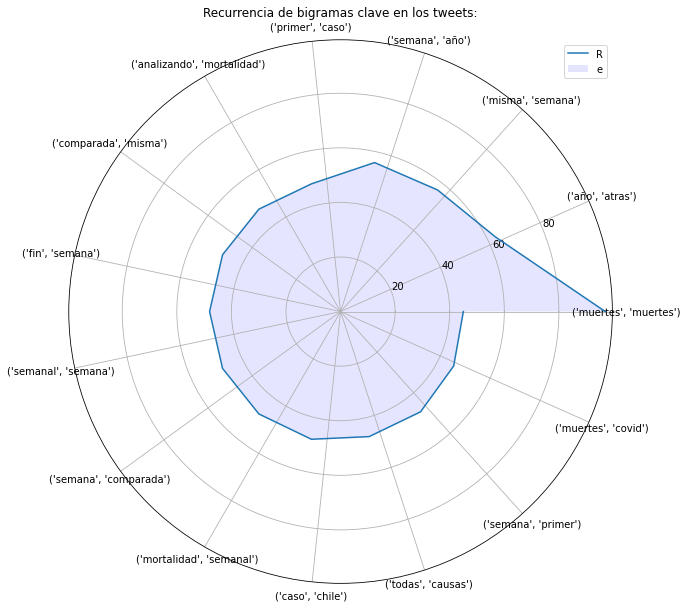

In [35]:
# mostrando TOP 15 bigramas recurrentes
key_bigrams = count_bigram_tweets[0:15].bigrams.to_list()
  
count_key_bigrams = count_bigram_tweets[0:15][0].to_list()
    
plt.figure(figsize =(14, 10)) 
plt.subplot(polar = True) 
    
theta = np.linspace(0, 2 * np.pi, len(count_key_bigrams)) 
    
lines, labels = plt.thetagrids(range(0, 360, int(360/len(key_bigrams))), 
                                                         (key_bigrams)) 
    
plt.plot(theta, count_key_bigrams) 
plt.fill(theta, count_key_bigrams, 'b', alpha = 0.1) 
    
    
plt.legend(labels =('Recurrencia de términos'),#, 'Expected'), 
           loc = 1) 
plt.title("Recurrencia de bigramas clave en los tweets:") 
    
plt.show() 